In [1]:
import os.path
import os
import math as m
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def gen_lattice(S0, u, d, N):
    """generates a binomial lattice
    
    for a given up, down, start value and number of steps (N).
    Resulting lattice has N+1 levels.
    """
    S = [float(S0)]

    for i in range(1, N+1):
        for j in range(0, i+1):
            S.append( S0 * d**j * u**(i-j) )

    return S


In [3]:
gen_lattice(S0=100., N=2, u=1.1, d=.9)

[100.0, 110.00000000000001, 90.0, 121.00000000000001, 99.00000000000001, 81.0]

The number of levels in a binomial lattice of length N is $\frac{\sqrt{8N+1}-1}{2}$

In [4]:
def lattice_levels(S):
    return int( round( (m.sqrt(8*len(S)+1)-1)/2 ) )

lattice visialisation based on idea from [link](http://www.theresearchkitchen.com/archives/738)

In [5]:
tmp = os.path.join(os.path.expanduser('~'), 'tmp')
if not os.path.exists(tmp):
    os.makedirs(tmp)

In [6]:
def dotlattice(S, filename, labels=True):
    f = open(filename, 'w')
    f.write("digraph G {\n")

    shape = "plaintext" if labels else "point"

    f.write("node[shape=%s, samehead=true, sametail=true];\n" % shape)
    f.write("rankdir=LR;\n")

    f.write("edge[arrowhead=none];\n")

    # Create a dot node for each element in the lattice
    for i in range(0, len(S)):
        f.write( "node%d[label=\"%g\"];\n" % (i+1, S[i]) )

    # The number of levels in a binomial lattice
    L = lattice_levels(S)

    k=1
    for i in range(1, L):
        tabs = "\t" * (i-1)
        j = i
        while( j>0 ):
            f.write("node%d->node%d;\n" % (k, k+i))
            f.write("node%d->node%d;\n" % (k, k+i+1))
            k = k + 1
            j = j - 1

    f.write("}\n")


(-0.5, 691.5, 418.5, -0.5)

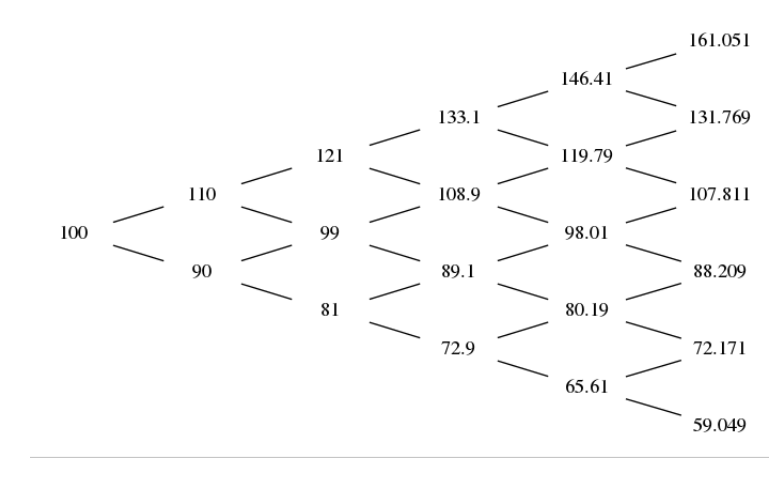

In [7]:
name="lattice"
dotlattice(gen_lattice(S0=100., N=5, u=1.1, d=0.9), filename=os.path.join(tmp, name+".dot") )
!dot -Tpng -o ~/tmp/{name}.png -v ~/tmp/{name}.dot 2> /dev/null

plt.figure(figsize=(16,8))
plt.imshow( mpimg.imread(os.path.join(tmp, name+".png")) )
plt.axis('off')

$0 < d < e^{r \Delta t} < u$

$u = e^{ \sigma \Delta t }$

$d = \frac{1}{u}$

$p = \frac{e^{r \Delta t} - d}{u - d}$ - вероятность движения вверх на каждом шаге

In [8]:
def calculate_price(call, European):
    #call ~ true => call, call ~ false => put
    #European ~ true => European, else => American
    r=0.05
    T=1.
    N=1000
    dt= T / N
    sigma=0.2
    u = np.exp(sigma*np.sqrt(dt))
    d = 1./u
    p = (np.exp(r*dt)-d)/(u-d)
    S0=100.
    S = gen_lattice(S0=S0, N=N, u=u, d=d)
    
    #Generate lattice
    L = lattice_levels(S)
    #print("levels: %d len: %d; number of first node on the last level: %d" % (L, len(S), len(S)-L))
    #print('---')
    for i in range(len(S)-L, len(S) ):
        if(call == 1): #For a call option
            S[i]=max(0,S[i]-100)
        else: #For a put option
            S[i]=max(0,100-S[i])
        #print(S[i])
    
    #print( '---')

    k=len(S)-L-1 # last index before the last level starts
    for i in reversed(range(1, L)):
        for j in range(0, i):
            if(European == 1 and call == 1): #For European call option
                S[k]= np.exp(-r*dt)*(p*S[k+i]+(1-p)*S[k+i+1])
            if(European == 0 and call == 1): #For American call option
                S[k]=max(np.exp(-r*dt)*(p*S[k+i]+(1-p)*S[k+i+1]),max(0,S[k]-100))
            if(European == 1 and call == 0): #For European put option
                S[k]= np.exp(-r*dt)*(p*S[k+i]+(1-p)*S[k+i+1])
            if(European == 0 and call == 0): #For American put option
                S[k]=max(np.exp(-r*dt)*(p*S[k+i]+(1-p)*S[k+i+1]),max(0,100-S[k]))
            #print("%f connected to %f and %f" % (S[k], S[k+i], S[k+i+1]))
            k = k - 1
    return S[0]

In [9]:
call = 1
European = 1
put = 0
American = 0
print (calculate_price(put, American))

6.08959528298


----------------